In [62]:
import pandas as pd
import networkx as nx
from math import exp
import matplotlib.pyplot as plt
import numpy as np
from itertools import count

In [40]:
nodes = pd.read_csv('routes.csv', header=None, names=['i', 'j'])
g = nx.from_pandas_edgelist(nodes, 'i', 'j',create_using=nx.DiGraph())
print('Number of nodes', g.number_of_nodes())
print('Number of edges', g.number_of_edges())

Number of nodes 151
Number of edges 3622


In [41]:
# We have a dataframe of countries (nodes)
countries = pd.read_csv('data.csv')
countries.set_index('country', inplace=True)
countries['population'] = 1000000*countries['population']
# Travellers are for an entire year, but our timeline is weekly
countries['travellers'] = countries['travellers']/52

countries.head()

,population,travellers,hdi
country,,,
Afghanistan,32760000.0,37113.596154,0.498
Albania,2900000.0,79730.769231,0.773
Algeria,39100000.0,54596.153846,0.747
Angola,26920000.0,23932.519231,0.581
Antigua and Barbuda,98000.0,19996.326923,0.780


In [44]:
# For each country, we need the travellers going from the neighboring countries
def return_list_neighbors(i, g):
    return [j for j in g.neighbors(i)]
print('Albania\'s neighbors :', return_list_neighbors('Albania', g))

# For all countries
def compute_sum_travelers_neighboring_countries(g):
    sum_travel_neighbors = []
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum_n = 0
        for n in neighbors:
            sum_n += countries.loc[n]['travellers']
        sum_travel_neighbors.append(sum_n)
    return sum_travel_neighbors
countries['sum_travel_neighbors'] = compute_sum_travelers_neighboring_countries(g)

countries.head()

Albania's neighbors : ['Austria', 'Germany', 'Greece', 'Italy', 'Slovenia', 'Turkey', 'United Kingdom']


,population,travellers,hdi,sum_travel_neighbors
country,,,,
Afghanistan,32760000.0,37113.596154,0.498,2.576400e+06
Albania,2900000.0,79730.769231,0.773,3.826346e+06
Algeria,39100000.0,54596.153846,0.747,1.192336e+07
Angola,26920000.0,23932.519231,0.581,9.411293e+06
Antigua and Barbuda,98000.0,19996.326923,0.780,6.018484e+06


In [43]:
# W_ij the weight between country i and j represents the number of travellers between i and j
def compute_edge_weight(i, j):
    return countries.loc[i]['travellers']*countries.loc[j]['travellers']/(countries.loc[i]['sum_travel_neighbors'])
        
def add_edge_weights():
    for e in g.edges():
        g[e[0]][e[1]]['weight'] = compute_edge_weight(e[0], e[1])

add_edge_weights()
print('France - Singapore :', g['France']['Singapore'])
print('Singapore - France :', g['Singapore']['France'])

France - Singapore : {'weight': 9472.863442029653}
Singapore - France : {'weight': 12656.470084309465}


In [52]:
# Initialisation for our model :
r0 = 5
alpha = 0.06
beta = 0.4
period = 10
mortality_rate = 0.15
country_start = 'France'
nb_infected_start = 1

# # Initialisation for t=0 :
countries['incubation0'] = np.zeros(countries.shape[0])
countries['sick0'] = np.zeros(countries.shape[0])
countries['dead0'] = np.zeros(countries.shape[0])
countries['infected0'] = np.zeros(countries.shape[0])
countries['healthy0'] = countries['population']
countries['incubation0'] = np.zeros(countries.shape[0])

# We infect the starting country with a certain number of people
countries.loc[country_start]['infected0'] = nb_infected_start
countries.loc[country_start]['incubation0'] = nb_infected_start
countries.loc[country_start]['healthy0'] = countries.loc[country_start]['population'] - countries.loc[country_start]['incubation0']

The reproduction number ri (average number of people that an incubated person will infect in a week) should :
- be inversly proportionate to the HDI (depending on the beta)
- Decrease with time (as awareness increases, and the immune system adjusts, etc) (depending on the alpha)

In [53]:
print('min HDI: ',countries.hdi.min())
print('max HDI: ',countries.hdi.max())
print('max HDI: ',countries.hdi.median())


min HDI:  0.354
max HDI:  0.946
max HDI:  0.747


In [70]:
# Contamination decreases with time
def time(t):
    return exp(-alpha*t)

# We calculate the average number infected by an incubated person in a week
# The higher the HDI of a country, the less people will be infected
def reproduction_number_by_country(t):
    minim=countries.hdi.min()
    maxim=countries.hdi.max()
    # Affine function of HDI :
    a=-2*beta*r0/(maxim-minim)
    b=beta*r0-a*minim
    return (r0 +a*countries['hdi'] + b)

ri = reproduction_number_by_country(1)
print('Country \t HDI \t RI')
print('Afghanistan : \t', countries.loc['Afghanistan']['hdi'], '\t',ri['Afghanistan'])
print('France : \t', countries.loc['France']['hdi'], '\t',ri['France'])

Country 	 HDI 	 RI
Afghanistan : 	 0.498 	 6.027027027027026
France : 	 0.894 	 3.35135135135135


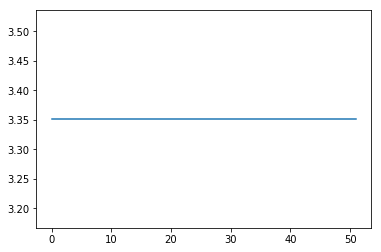

In [71]:
RNC_time=[reproduction_number_by_country(t)['France'] for t in range(52)]
exp_test=[time(t) for t in range(52)]
plt.plot(RNC_time)

(array([25., 17., 24., 25., 18., 12., 10., 12.,  6.,  2.]),
 array([4.81053324, 4.92203816, 5.03354308, 5.145048  , 5.25655292,
        5.36805784, 5.47956276, 5.59106768, 5.7025726 , 5.81407752,
        5.92558245]),
 <a list of 10 Patch objects>)

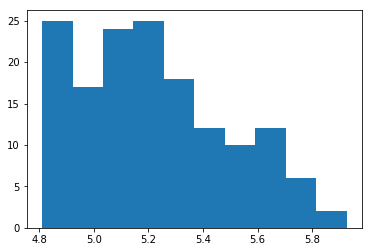

In [72]:
test1 = ((1 -beta*countries['hdi'])*r0 + beta*r0)*exp(-alpha*1)
plt.hist(test1)

(array([25., 17., 24., 25., 18., 12., 10., 12.,  6.,  2.]),
 array([3.78409947, 3.87181235, 3.95952523, 4.0472381 , 4.13495098,
        4.22266386, 4.31037674, 4.39808961, 4.48580249, 4.57351537,
        4.66122824]),
 <a list of 10 Patch objects>)

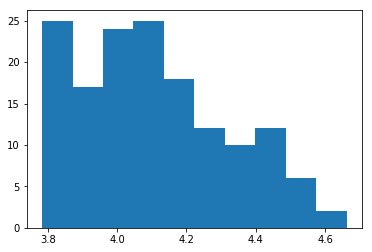

In [73]:
test5 = ((1 -beta*countries['hdi'])*r0 + beta*r0)*exp(-alpha*5)
plt.hist(test5)

In [74]:
# Incubated people staying in the country at time t
def number_incubated_staying(t):
    incubated_staying = {}
    for i in countries.index:
        incubated_staying[i] = countries.loc[i]['incubation'+str(t-1)]*(1 - 
                    countries.loc[i]['travellers']/(countries.loc[i]['population'] - 
                    countries.loc[i]['dead'+str(t-1)] - countries.loc[i]['sick'+str(t-1)]))
    return incubated_staying
# Incubated people coming to the country at time t
def number_incubated_coming(t):
    incubated_coming = {}
    for i in countries.index:
        neighbors = return_list_neighbors(i, g)
        sum = 0
        for j in neighbors:
            sum += g[j][i]['weight']*countries.loc[j]['incubation'+str(t-1)]/(countries.loc[j]['population'] - 
                                countries.loc[j]['dead'+str(t-1)] - countries.loc[j]['sick'+str(t-1)])
        incubated_coming[i] = sum
    return incubated_coming

incubated_coming = number_incubated_coming(1)
print('Number of incubated staying in France :', number_incubated_staying(1)['France'])
print('Number of incubated coming to France :', incubated_coming['France'])
print('Number of incubated coming to Germany :', incubated_coming['Germany'])
print('Number of incubated coming to the UK :', incubated_coming['United Kingdom'])

sum = 0
for n in return_list_neighbors('France', g):
    sum += incubated_coming[n]
print('For all of France\' neighbors :', sum)

KeyError: 'Afghanistan'

In [75]:
def infection_impact(t):
    ri = reproduction_number_by_country(t)
    incubated_staying = number_incubated_staying(t)
    incubated_coming = number_incubated_coming(t)
    
    countries['dead'+str(t)] = mortality_rate*countries['sick'+str(t-1)]
    
    infected = []
    for i in countries.index:
        tmp = (incubated_staying[i] + incubated_coming[i])*(1 + ri[i])
        if tmp <= countries.loc[i]['population']:
            infected.append(tmp)
        else:
            infected.append(countries.loc[i]['population'])
    countries['infected'+str(t)] = infected
    '''countries['infected'+str(t)] = [(incubated_staying[i] 
                + incubated_coming[i])*(1 + ri[i]) if ((incubated_staying[i] 
                + incubated_coming[i])*(1 + ri[i]) <= countries.loc[i]['population']) for i in countries.index]'''
    
    countries['healthy'+str(t)] = [countries.loc[i]['population'] - countries.loc[i]['infected'+str(t)] for i in countries.index]
    countries['sick'+str(t)] = countries['incubation'+str(t - 1)] 
    countries['incubation'+str(t)] = countries['infected'+str(t)] - countries['sick'+str(t)]

print('Country : \t Infected \t Dead')
for p in range(1, period):
    infection_impact(p)
    print(p)
    print('France : \t', round(countries.loc['France']['infected'+str(p)], 3), '\t',
                      round(countries.loc['France']['dead'+str(p)], 3))
    print('Germany : \t', round(countries.loc['Germany']['infected'+str(p)], 3), '\t',
                       round(countries.loc['Germany']['dead'+str(p)], 3))
    print('UK : \t \t', round(countries.loc['United Kingdom']['infected'+str(p)], 3), '\t',
                  round(countries.loc['United Kingdom']['dead'+str(p)], 3))
    print('Afghanistan : \t', round(countries.loc['Afghanistan']['infected'+str(p)], 3), '\t',
                           round(countries.loc['Afghanistan']['dead'+str(p)], 3))

Country : 	 Infected 	 Dead


KeyError: 'Afghanistan'

In [76]:
countries.loc['Afghanistan']

population              3.276000e+07
travellers              3.711360e+04
hdi                     4.980000e-01
sum_travel_neighbors    2.576400e+06
incubation0             0.000000e+00
sick0                   0.000000e+00
dead0                   0.000000e+00
infected0               0.000000e+00
healthy0                3.276000e+07
Name: Afghanistan, dtype: float64

In [52]:
for p in range(period+1):
    nx.set_node_attributes(g, countries['infected'+str(p)].to_dict(), 'infected'+str(p))
nx.get_node_attributes(g, 'infected5')

{'Afghanistan': 1.9699431134236336,
 'Azerbaijan': 27.379220690021295,
 'India': 105.0286373737525,
 'Iran': 78.84421464315055,
 'Kuwait': 0.9446383046868136,
 'Tajikistan': 0.006697447147391298,
 'Turkey': 25.363304386356386,
 'United Arab Emirates': 139.55313263453488,
 'Albania': 0.5087592223614302,
 'Austria': 29.74257759953861,
 'Germany': 181.1042885147547,
 'Greece': 23.735334372385257,
 'Italy': 76.36903118301309,
 'Slovenia': 18.328985830794924,
 'United Kingdom': 132.58087380505927,
 'Algeria': 17.967468861184237,
 'Belgium': 32.88619289052178,
 'Burkina Faso': 9.254931391830056,
 'Canada': 90.48717751041171,
 'China': 464.1072233135993,
 "Cote d'Ivoire": 23.04705268407456,
 'Egypt': 55.28804233830122,
 'France': 20282.016886901445,
 'Jordan': 4.34409103106262,
 'Lebanon': 8.410619100933754,
 'Libya': 0.2884778213808937,
 'Malta': 0.9825166402351122,
 'Morocco': 28.5954797925655,
 'Niger': 0.11858375862138495,
 'Portugal': 4.502563514044857,
 'Russia': 137.03979952166563,
 'S

In [53]:
# get unique groups
groups = set(nx.get_node_attributes(g,'infected5').values())
mapping = dict(zip(sorted(groups),count()))
nodes = g.nodes()
colors = [mapping[g.node[n]['infected5']] for n in nodes]]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

SyntaxError: invalid syntax (<ipython-input-53-1229e4fbec83>, line 5)